<a href="https://colab.research.google.com/github/starkdg/pyConvnetPhash/blob/master/train_pca_with_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub

model_dir = "/gdrive/My Drive/models"
module_inception_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/2"

module = hub.Module(module_url)
target_height, target_width = hub.get_expected_image_size(module)

n_inputs = 1792
ndims = 256

# location of testing .tfrecord files
training_files_dir = "/gdrive/My Drive/imageset/train"
validation_files_dir = "/gdrive/My Drive/imageset/validation"
testing_files_dir = "/gdrive/My Drive/imageset/test"

batch_size = 500
norm_constant = 5.0               # input normalization constant (divide input features by)

# location and file of exported frozen model file
frozen_model = "/gdrive/My Drive/models/svd/mobilenetv2_pca_from_svd_{0}to{1}_frozen_model.pb".format(n_inputs, ndims)

print("module: ", module_url)
print("target height: ", target_height)
print("target width: ", target_height)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


W0313 17:02:16.692550 140596169848704 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Instructions for updating:
Colocations handled automatically by placer.


W0313 17:02:17.436780 140596169848704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


module:  https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/2
target height:  224
target width:  224


In [0]:
def get_tfrecord_files(path):
  files = []
  for entry in os.scandir(path):
    if entry.is_file() and entry.name.endswith('.tfrecord'):
             files.append(entry.path)
  return files
  
  
def _parse_example(example):
  features = {'height': tf.FixedLenFeature([], tf.int64),
              'width': tf.FixedLenFeature([], tf.int64),
              'image_raw': tf.FixedLenFeature([], tf.string)}
  parsed_features = tf.parse_single_example(example, features)
  img = tf.io.decode_raw(parsed_features['image_raw'], tf.uint8)
  height = tf.cast(parsed_features['height'], tf.int32)
  width = tf.cast(parsed_features['width'], tf.int32)

  img_reshaped = tf.manip.reshape(img, [height, width, 3])
  imgfl = tf.image.convert_image_dtype(img_reshaped, dtype=tf.float32)
  img_norm = tf.expand_dims(imgfl, 0)
  img_resized = tf.image.resize_bicubic(img_norm, [target_height, target_width])
  img_resized = tf.squeeze(img_resized, 0)
  return img_resized


def input_function(path, batch_size=1, num_epochs=None, shuffle=False):
  tfrecords = get_tfrecord_files(path)
  dataset = tf.data.TFRecordDataset(tfrecords)
  dataset = dataset.map(_parse_example)
  if (shuffle):
    dataset = dataset.shuffle(10000)
  dataset = dataset.batch(batch_size).repeat(num_epochs)
  iterator = dataset.make_initializable_iterator()
  return iterator

In [0]:
def create_pca_model():

  x = tf.placeholder(tf.float32, shape=(None, n_inputs), name="input")  
    
  with tf.variable_scope("weights", reuse=tf.AUTO_REUSE):
    wts = tf.get_variable('w', initializer=tf.zeros(shape=(n_inputs, n_inputs), dtype=tf.float32))
    
  # input_dims -> ndims
  output    = tf.matmul(x, wts, name="output")
  output512 = tf.matmul(x, tf.slice(wts, [0,0], [n_inputs, 512]), name='output512')
  output256 = tf.matmul(x, tf.slice(wts, [0,0], [n_inputs, 256]), name='output256')
  output128 = tf.matmul(x, tf.slice(wts, [0,0], [n_inputs, 128]), name='output128')
  output64  = tf.matmul(x, tf.slice(wts, [0,0], [n_inputs,  64]), name='output64')
  output32  = tf.matmul(x, tf.slice(wts, [0,0], [n_inputs,  32]), name='output32')  
  
  return wts, output

In [0]:
def covariance(x):
  mean_x = tf.reduce_mean(x, axis=0, keep_dims=True)
  mx = tf.matmul(tf.transpose(mean_x), mean_x)
  vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0]-1, tf.float32)
  cov_xx = vx - mx
  return cov_xx 

In [0]:
def train_pca_model(training_files_dir, batch_size):

  wts, output = create_pca_model()  
   
  training_iter = input_function(training_files_dir, batch_size)
  training_images = training_iter.get_next()
  training_features = module(training_images)
  
  cov_mat = covariance(training_features)
  s, u, v = tf.linalg.svd(cov_mat, full_matrices=True, compute_uv=True)
  new_wts = tf.assign(wts, tf.transpose(u))
  cumsum_s = tf.math.cumsum(s) / tf.math.reduce_max(s)
  
  # execute graph
  print("Train PCA by SVD")
  init = tf.global_variables_initializer()
  sess = tf.Session()
  sess.run(init)
  sess.run([training_iter.initializer])
  features = sess.run(training_features)
  features = sess.run(training_features)
  cs, w = sess.run([cumsum_s, new_wts])
   
  plt.figure(1)
  plt.plot(cs)
  plt.xlabel('no. leading eigen vectors')
  plt.ylabel('cumulative sum')
  plt.title('Cumulative Sum of Leading Eigen Vectors')
  plt.show()
    
  plt.figure(2)
  plt.hist(w.ravel(), bins=100, histtype='bar')
  plt.title('histogram of weights')
  plt.show()
    

  print("freeze graph ...")  
  out_nodes = ['output', 'output512', 'output256', 'output128', 'output64', 'output32']
  graphdef = tf.get_default_graph().as_graph_def()
  subgraphdef = tf.compat.v1.graph_util.extract_sub_graph(graphdef, out_nodes)
  subgraphdef_frozen = tf.compat.v1.graph_util.convert_variables_to_constants(sess, subgraphdef, out_nodes)
    
  print("write model: ", frozen_model)
  with tf.gfile.GFile(frozen_model, "wb") as f:
    f.write(subgraphdef_frozen.SerializeToString())
    
  sess.close() 
   
  

Train autoencoder
training files:  /gdrive/My Drive/imageset/train
batch size:  500
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0313 17:02:20.729004 140596169848704 saver.py:1483] Saver not created because there are no variables in the graph to restore


Train PCA by SVD


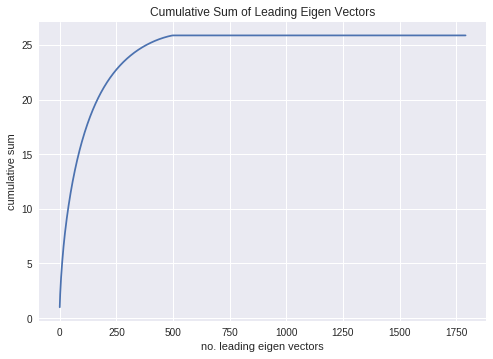

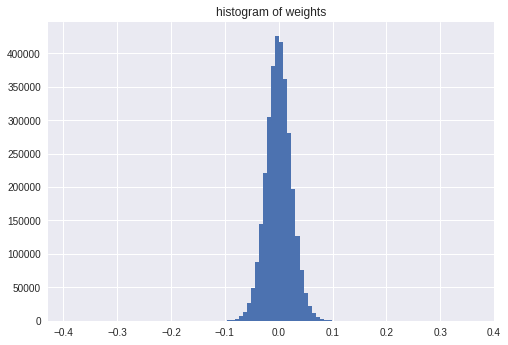

freeze graph ...
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


W0313 17:03:00.929595 140596169848704 deprecation.py:323] From <ipython-input-5-3ce7db3ff045>:40: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


W0313 17:03:00.970643 140596169848704 deprecation.py:323] From <ipython-input-5-3ce7db3ff045>:41: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


INFO:tensorflow:Froze 1 variables.


I0313 17:03:01.061745 140596169848704 graph_util_impl.py:268] Froze 1 variables.


INFO:tensorflow:Converted 1 variables to const ops.


I0313 17:03:01.089586 140596169848704 graph_util_impl.py:301] Converted 1 variables to const ops.


write model:  /gdrive/My Drive/models/svd/mobilenetv2_pca_from_svd_1792to256_frozen_model.pb


In [0]:
print("Train autoencoder")
print("training files: ", training_files_dir)
print("batch size: ", batch_size)

train_pca_model(training_files_dir, batch_size)
